In [1]:
import os
import sys
from omegaconf import OmegaConf
import numpy as np
import pandas as pd


# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.validity.validity_criteria import validate_polarization_curves
from src.surrogate_models.surrogate_model_io import save_cv_results
from src.FE.FE_formatting import load_parameter_ranges
from src.validity.surrogate_model_validation import ensure_numeric_dataframe
from src.analysis.surrogate_models_training import nested_cv_train_with_groups

##  **Project overview**
**Goal:** Train surrogate models (Random Forest / XGBoost) to predict PEM fuel cell polarization behavior, using grouped nested cross-validation for honest evaluation.

**Outputs:** best hyperparameters, fold-wise metrics, saved models, and residual CSVs (per fold, with features) to analyze error patterns.

### **Configs**
To guarantee reproducibility, store your configuration files as versioned YAML.
- grid_search_cfg: hyperparameter search space for each model..
- core_training_cfg: core settings like number of CV splits, scoring, n_jobs, etc.
- regions_cfg: numeric bounds for polarization regions.


In [13]:
# we load the configuration files
grid_search = OmegaConf.load('../configs/grid_search_cfg.yaml')
core_training = OmegaConf.load('../configs/core_training_cfg.yaml')
regions = OmegaConf.load('../configs/regions_cfg.yaml')

### **Data & features** 

**Inputs:** a table of experiments/simulations. Columns = engineered features; target = response variable for the polarization curve.

**Groups:** we group by SHA256 so that all rows from the same original sample stay together in either train or test during CV.

**Assumption:** the last column of X is the current density. We use it to compute region masks (activation / ohmic / mass-transport) for region-wise metrics.

If your last column changes, update the region mask code accordingly.

In [16]:
sys.path.append(os.path.abspath("../external/AlphaPEM"))
data = pd.read_pickle(r"../data/processed/validated_final_57344.pkl")
data = data[data['classification'] == 'valid']
param_config,parameter_ranges, parameter_names= load_parameter_ranges('../configs/param_config.yaml')
data["classification"].value_counts()

classification
valid    56312
Name: count, dtype: int64

In [17]:
valid_criteria = OmegaConf.load('../configs/valid_polarization_curve_cfg.yaml')
validated_df = validate_polarization_curves(
    data,
    apply_criteria=valid_criteria['criteria'],
    filter_invalid=True,
    voltage_range=valid_criteria['voltage_range'],
    approx_monotonic_threshold=valid_criteria['approx_monotonic_threshold']
)

print(len(validated_df))  ## Should be 54754

54754


In [18]:
columns = list(parameter_ranges.keys())
columns.extend(['Ucell', 'ifc', 'SHA256'])

n_configs = 5
sampled_df = validated_df.sample(n=n_configs, random_state=42).reset_index(drop=True)

# Explode both columns together
df_exploded = sampled_df[columns].explode(['ifc', 'Ucell'], ignore_index=True)

print("\nExploded DataFrame:")
print(len(df_exploded))
df_exploded.head()


Exploded DataFrame:
155


,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,e,Re,i0_c_ref,kappa_co,kappa_c,Ucell,ifc,SHA256
0,343.804109,214920.650007,2.431343,0.48481,0.731942,3.325909,0.289988,0.198927,5,0.000003,40.551519,33.053013,0.177528,0.971062,0.000813,f1bb7220e0a9e4d7ec051d321cbc53c20910f205e6f7fb...
1,343.804109,214920.650007,2.431343,0.48481,0.731942,3.325909,0.289988,0.198927,5,0.000003,40.551519,33.053013,0.177528,0.927253,0.100812,f1bb7220e0a9e4d7ec051d321cbc53c20910f205e6f7fb...
2,343.804109,214920.650007,2.431343,0.48481,0.731942,3.325909,0.289988,0.198927,5,0.000003,40.551519,33.053013,0.177528,0.8958,0.200812,f1bb7220e0a9e4d7ec051d321cbc53c20910f205e6f7fb...
3,343.804109,214920.650007,2.431343,0.48481,0.731942,3.325909,0.289988,0.198927,5,0.000003,40.551519,33.053013,0.177528,0.87028,0.300812,f1bb7220e0a9e4d7ec051d321cbc53c20910f205e6f7fb...
4,343.804109,214920.650007,2.431343,0.48481,0.731942,3.325909,0.289988,0.198927,5,0.000003,40.551519,33.053013,0.177528,0.848665,0.400812,f1bb7220e0a9e4d7ec051d321cbc53c20910f205e6f7fb...


In [19]:
# We just use records with Ucell >= 0
df_exploded = df_exploded[df_exploded["Ucell"] >= 0]

X = df_exploded[list(parameter_ranges.keys()) + ['ifc']]
X = ensure_numeric_dataframe(X)

y = df_exploded['Ucell'].astype(float)

[WARN] Found non-numeric columns: ['ifc']
[INFO] Converted column 'ifc' to numeric.


## **XGBoost training**

### **Cross-validation strategy** 
We use nested CV with groups to avoid optimistic bias from tuning and evaluating on the same data.

- Outer CV (e.g., K folds): estimates generalization—never sees the inner loop.
- Inner CV: tunes hyperparameters using only the outer-train split.
- Grouping by SHA256: prevents leakage (no duplicate/related samples across train/test).

In [22]:
model_xgb, best_params_xgb, metrics_xgb = save_cv_results(
    X=X,
    y=y,
    groups=df_exploded['SHA256'],
    model_name='xgboost',
    cv_fn= nested_cv_train_with_groups,   # change for nested_cv_train_with_groups if outer cv is wanted
    core_training_cfg = core_training,
    grid_search_cfg= grid_search,
    regions_cfg=regions,
    run_name='test'
)

[INFO] Running CV function: nested_cv_train_with_groups
⚙️  Running nested CV with groups...
[INFO] Model: xgboost
[INFO] Samples: 155, Groups: 5
[INFO] Outer Folds: 5, Inner Folds: 3
[INFO] Hyperparameter grid: 72 combinations


🔁 Fold 1/5
[INFO] Fold 1 — R²: 0.4124, RMSE: 0.1392, MAE: 0.1384
[INFO] Saved residuals and features to ../results/surrogate_models/residuals_by_fold\residuals_fold_1_xgboost_20250815_222532.csv

🔁 Fold 2/5
[INFO] Fold 2 — R²: 0.1634, RMSE: 0.1063, MAE: 0.0967
[INFO] Saved residuals and features to ../results/surrogate_models/residuals_by_fold\residuals_fold_2_xgboost_20250815_222536.csv

🔁 Fold 3/5
[INFO] Fold 3 — R²: 0.9938, RMSE: 0.0119, MAE: 0.0086
[INFO] Saved residuals and features to ../results/surrogate_models/residuals_by_fold\residuals_fold_3_xgboost_20250815_222540.csv

🔁 Fold 4/5
[INFO] Fold 4 — R²: 0.6997, RMSE: 0.0886, MAE: 0.0750
[INFO] Saved residuals and features to ../results/surrogate_models/residuals_by_fold\residuals_fold_4_xgboost_2025081

## **Random Forest**

In [23]:
columns = list(parameter_ranges.keys())
columns.extend(['Ucell', 'ifc', 'SHA256'])

n_configs = 5
sampled_df = validated_df.sample(n=n_configs, random_state=42).reset_index(drop=True)

# Explode both columns together
df_exploded = sampled_df[columns].explode(['ifc', 'Ucell'], ignore_index=True)

print("\nExploded DataFrame:")
print(len(df_exploded))


df_exploded = df_exploded[df_exploded["Ucell"] >= 0]

X = df_exploded[list(parameter_ranges.keys()) + ['ifc']]
X = ensure_numeric_dataframe(X)

y = df_exploded['Ucell'].astype(float)


Exploded DataFrame:
155
[WARN] Found non-numeric columns: ['ifc']
[INFO] Converted column 'ifc' to numeric.


In [24]:
model_rf, best_params_rf, metrics_rf = save_cv_results(
    X=X,
    y=y,
    groups=df_exploded['SHA256'],
    model_name='rf',
    cv_fn= nested_cv_train_with_groups,   # change for nested_cv_train_with_groups if outer cv is wanted
    core_training_cfg = core_training,
    grid_search_cfg= grid_search,
    regions_cfg= regions,
    run_name='rf_nconfig_5000_no_neg_with_outerCV_metrics_for_regions'
)

[INFO] Running CV function: nested_cv_train_with_groups
⚙️  Running nested CV with groups...
[INFO] Model: rf
[INFO] Samples: 155, Groups: 5
[INFO] Outer Folds: 5, Inner Folds: 3
[INFO] Hyperparameter grid: 27 combinations


🔁 Fold 1/5
[INFO] Fold 1 — R²: 0.2890, RMSE: 0.1531, MAE: 0.1512
[INFO] Saved residuals and features to ../results/surrogate_models/residuals_by_fold\residuals_fold_1_rf_20250815_222611.csv

🔁 Fold 2/5
[INFO] Fold 2 — R²: 0.0765, RMSE: 0.1117, MAE: 0.0995
[INFO] Saved residuals and features to ../results/surrogate_models/residuals_by_fold\residuals_fold_2_rf_20250815_222618.csv

🔁 Fold 3/5
[INFO] Fold 3 — R²: 0.9976, RMSE: 0.0074, MAE: 0.0058
[INFO] Saved residuals and features to ../results/surrogate_models/residuals_by_fold\residuals_fold_3_rf_20250815_222624.csv

🔁 Fold 4/5
[INFO] Fold 4 — R²: 0.9971, RMSE: 0.0088, MAE: 0.0069
[INFO] Saved residuals and features to ../results/surrogate_models/residuals_by_fold\residuals_fold_4_rf_20250815_222631.csv

🔁 Fold 5/5


## **XGBoost Residual Plots**

In [2]:
from src.visualization.residual_plots import plot_residuals_vs_ifc, plot_residuals_by_ifc_boxplots, plot_residuals_hist

In [ ]:
def process_residuals(file_path, tolerance=0.05, max_points=31):
    df = pd.read_csv(file_path)

    config_ids = []
    current_config = 1
    point_in_config = 1
    last_y = df['y_true'].iloc[0]

    config_ids.append(f"config{current_config}")
    current_indices = [1]

    for i in range(1, len(df)):
        y = df['y_true'].iloc[i]
        delta = y - last_y

        # Check if new configuration starts:
        if delta > tolerance or point_in_config >= max_points:
            current_config += 1
            point_in_config = 1
        else:
            point_in_config += 1

        config_ids.append(f"config{current_config}")
        current_indices.append(point_in_config)
        last_y = y

    df['configuration'] = config_ids
    df['current_density_index'] = current_indices

    return df

In [4]:
def map_current_density(df):
    # Mapping from index (1–30) to current density values
    current_density_map = {
        i + 1: val for i, val in enumerate([
            0.000820796, 0.10081943643864154, 0.20081943643848774, 0.3008194364384895,
            0.4008194364384925, 0.5008194364384955, 0.6008194364384984, 0.7008194364385013,
            0.8008194364385044, 0.9008194364385074, 1.0008194364385103, 1.100819436438513,
            1.2008194364385163, 1.3008194364385193, 1.400819436438522, 1.500819436438525,
            1.600819436438515, 1.7008194364385032, 1.800819436438491, 1.9008194364384792,
            2.0008194364384675, 2.1008194364384556, 2.2008194364384437, 2.300819436438432,
            2.400819436, 2.5008194364384084, 2.600819436438396, 2.7008194364383846,
            2.8008194364383727, 2.900819436438361
        ])
    }

    # Create a new column with actual current density values
    df['ifc'] = df['current_density_index'].map(current_density_map)

    return df

In [12]:
residual_dfs = []
for fold in range(1, 6):
    file_path = f"../results/surrogate_models/xgboost/residuals/residuals_fold{fold}.csv"
    df_processed = process_residuals(file_path)
    df_processed.groupby("configuration").max("current_density_index")["current_density_index"].value_counts()
    df = map_current_density(df_processed)
    residual_dfs.append(df)

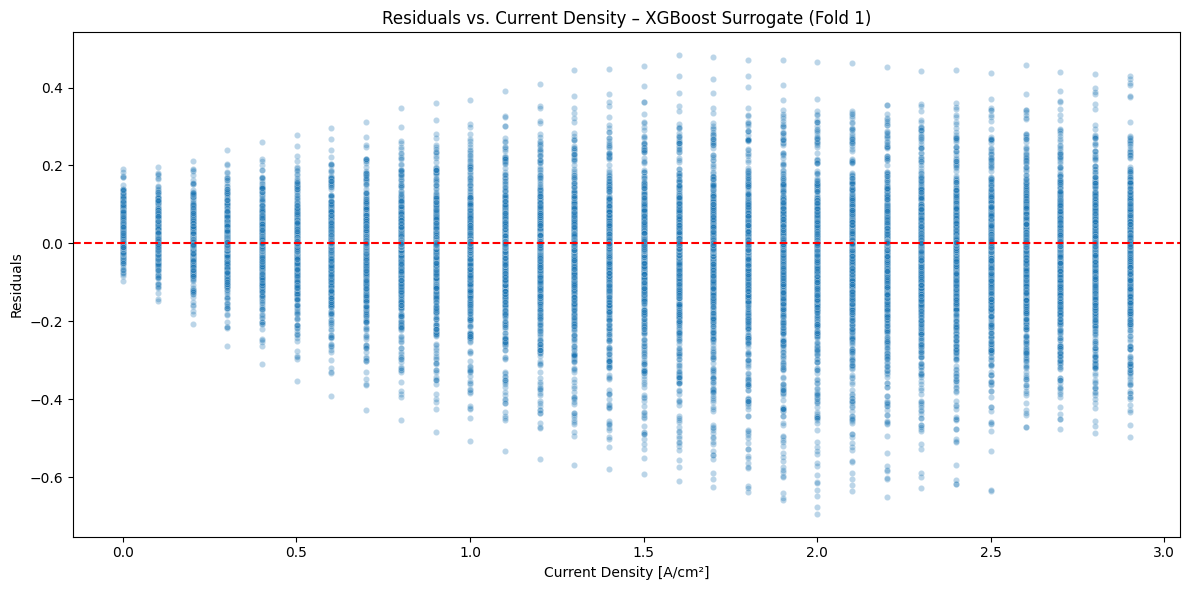

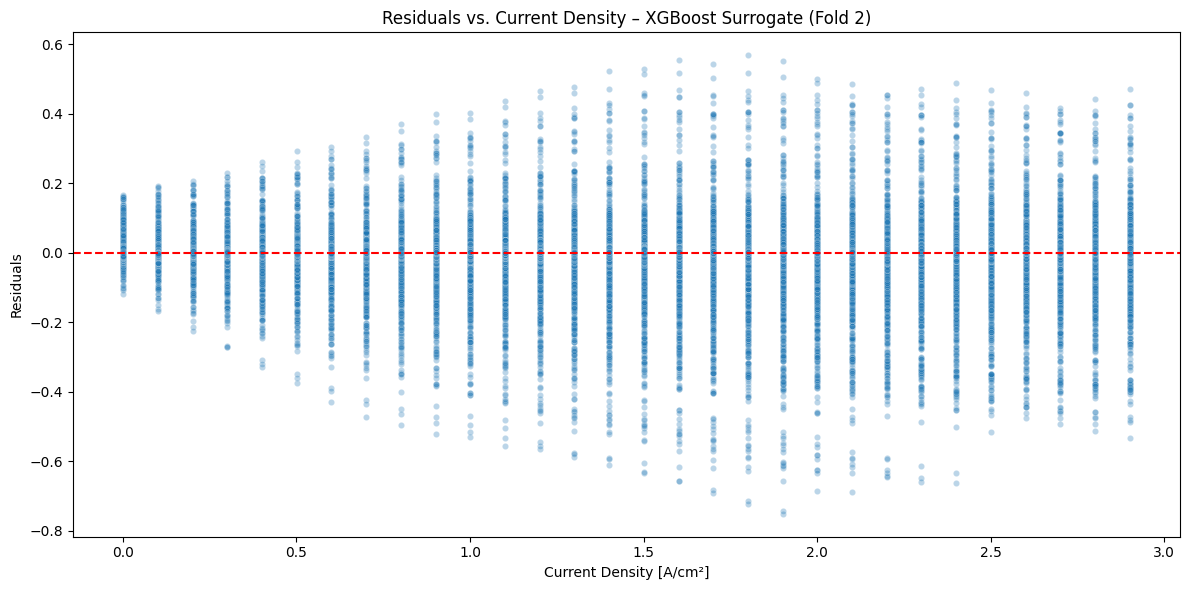

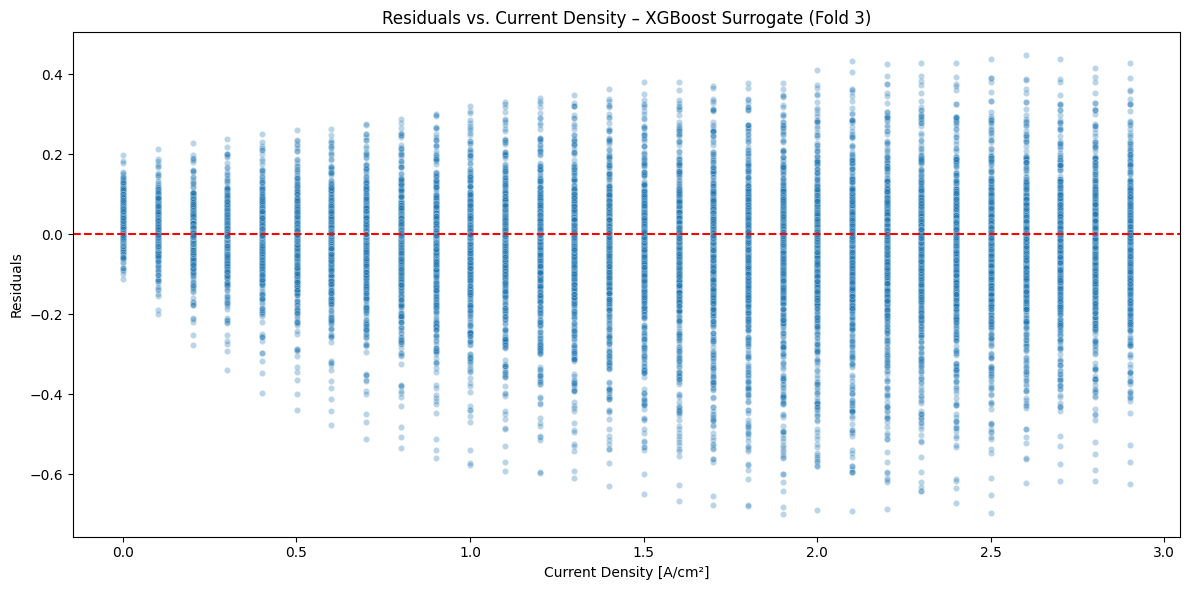

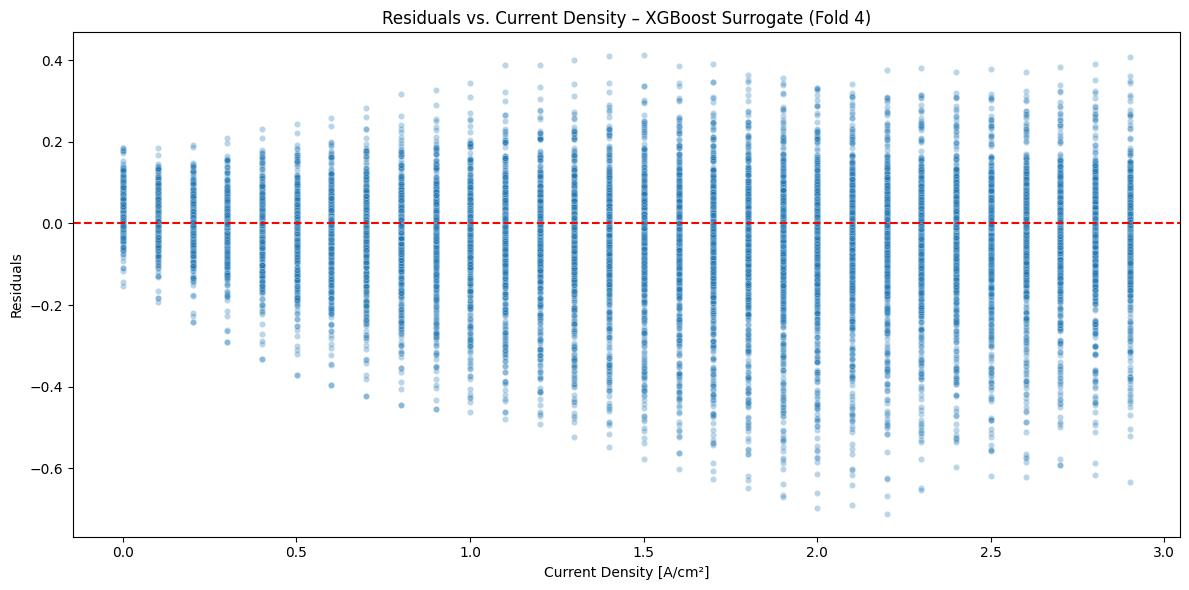

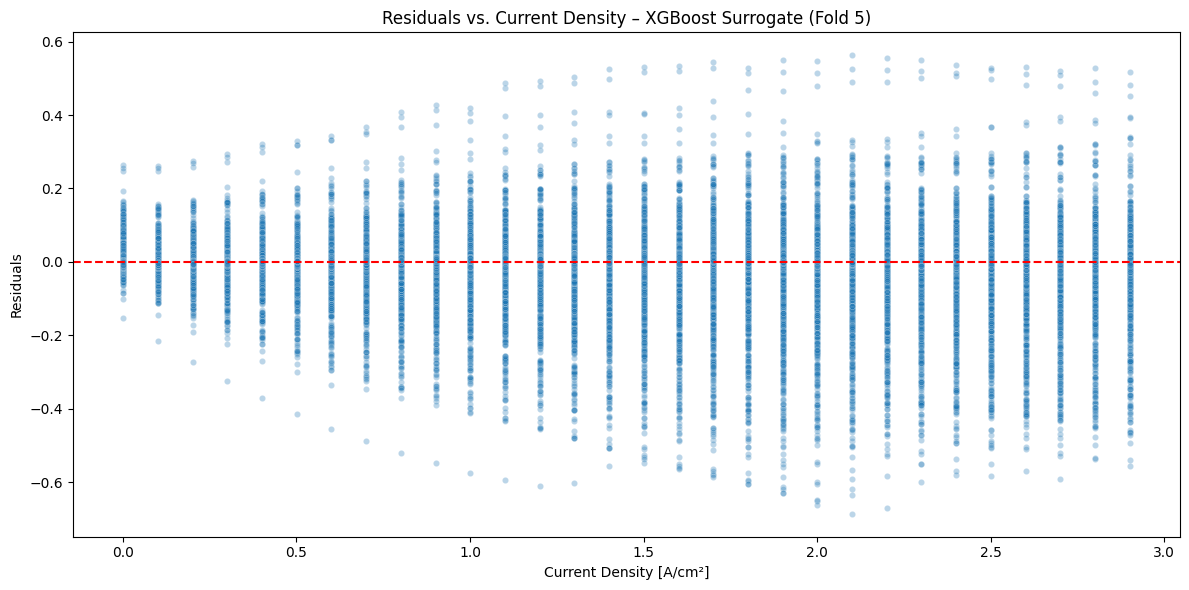

In [ ]:
for fold, df in enumerate(residual_dfs, start=1):
    plot_residuals_vs_ifc(df['ifc'], df['residual'], figsize=(12, 6), alpha=0.3, s=20, title=f"Residuals vs. Current Density – XGBoost Surrogate (Fold {fold})")

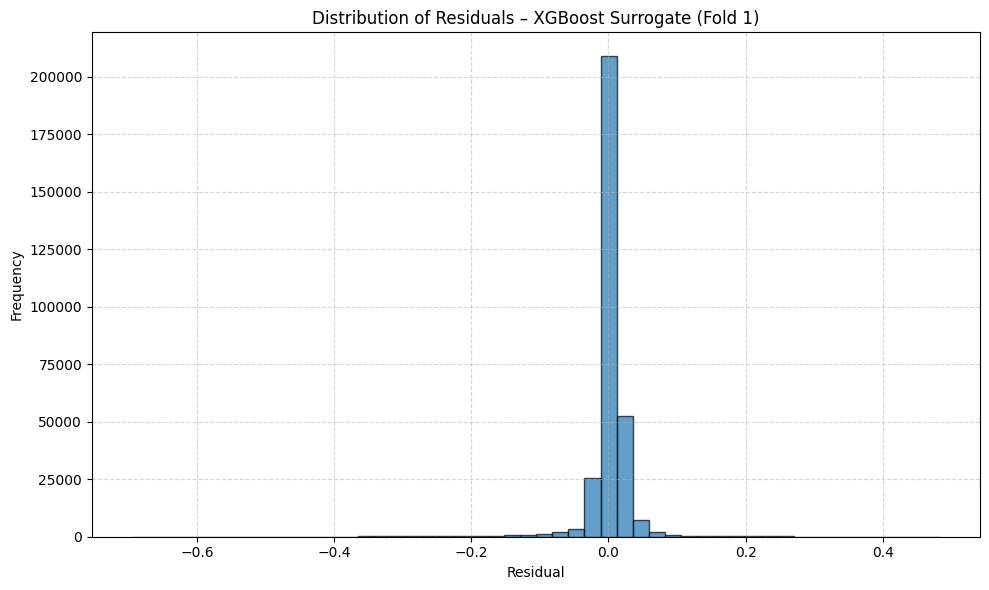

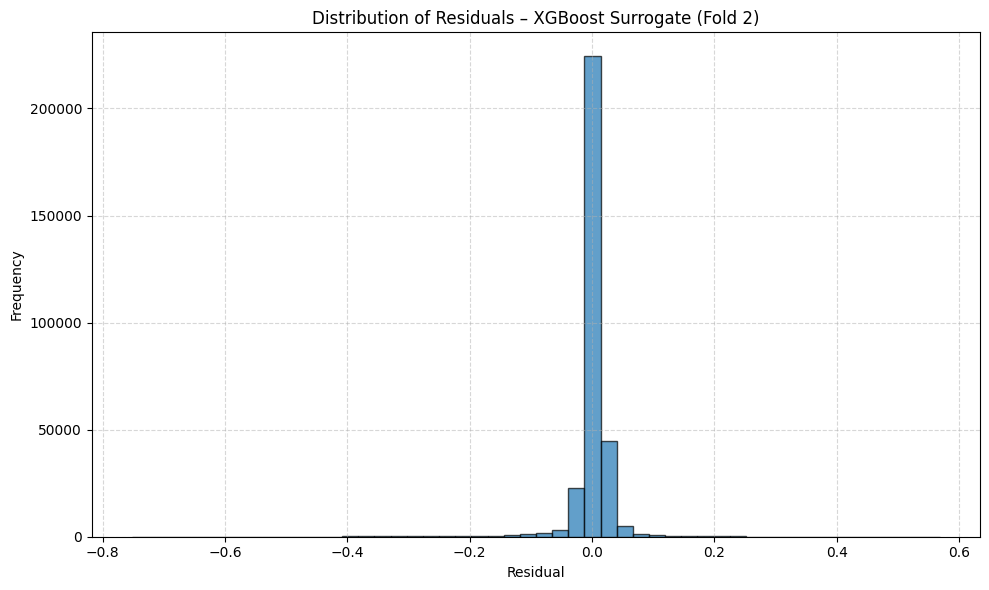

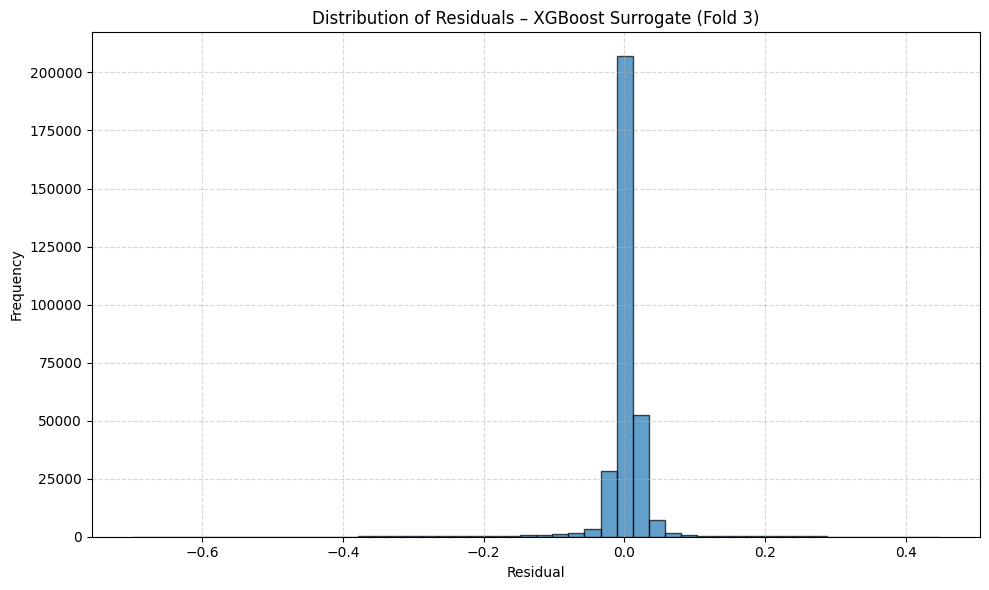

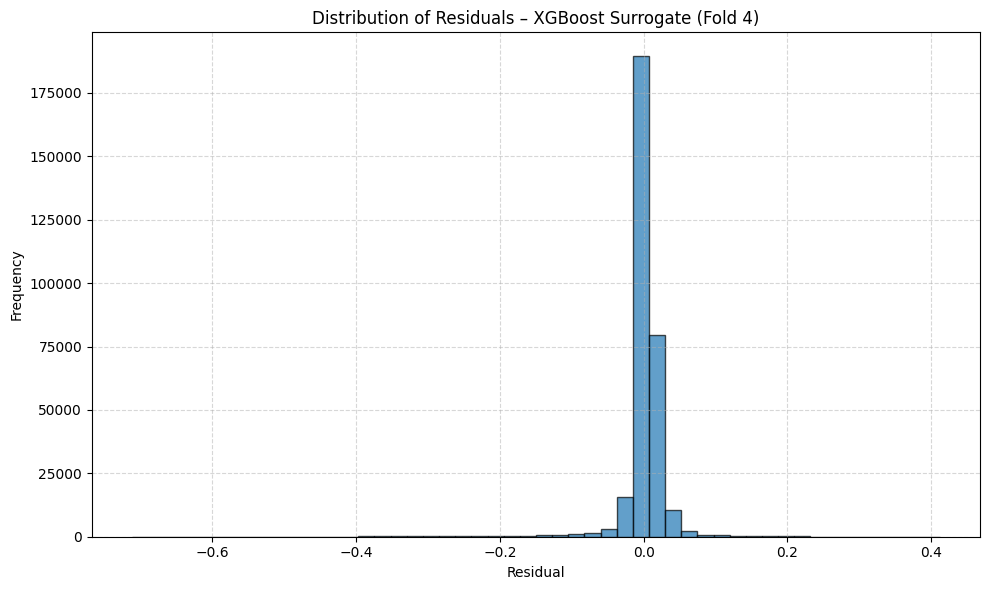

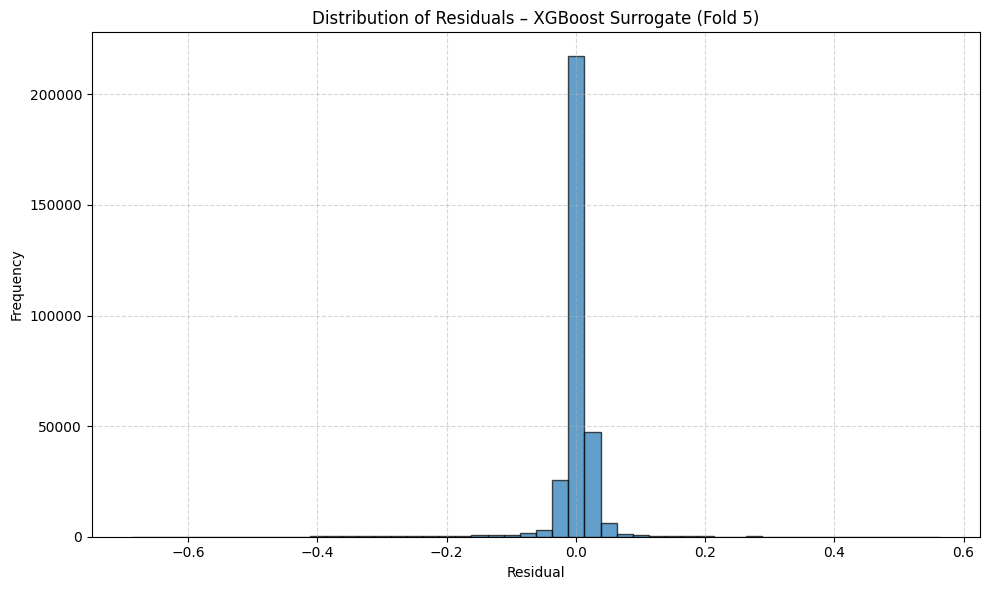

In [14]:
for fold, df in enumerate(residual_dfs, start=1):
    plot_residuals_hist(df['residual'], figsize=(10, 6), title=f"Distribution of Residuals – XGBoost Surrogate (Fold {fold})")

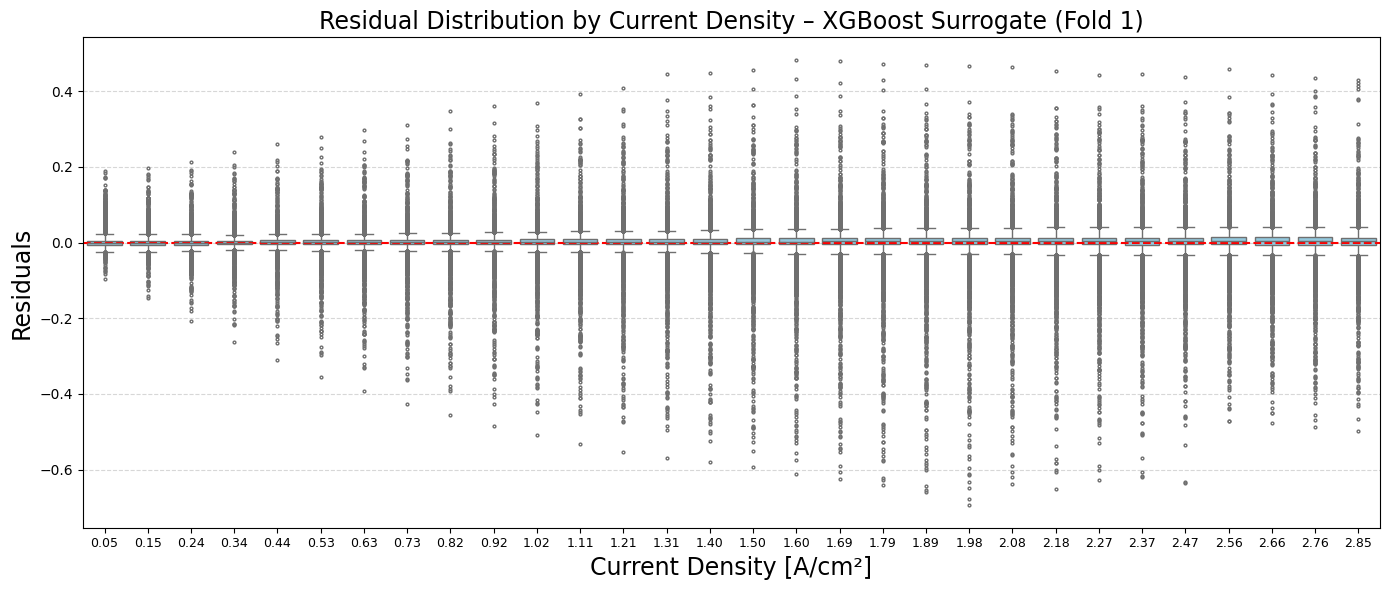

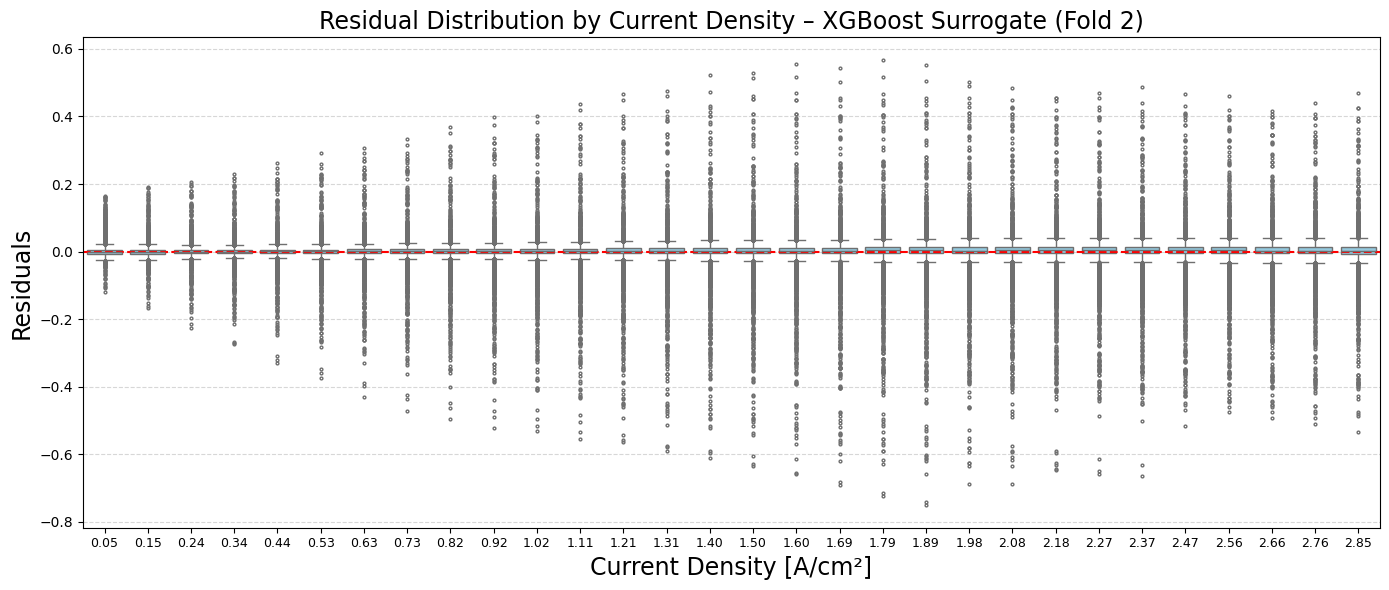

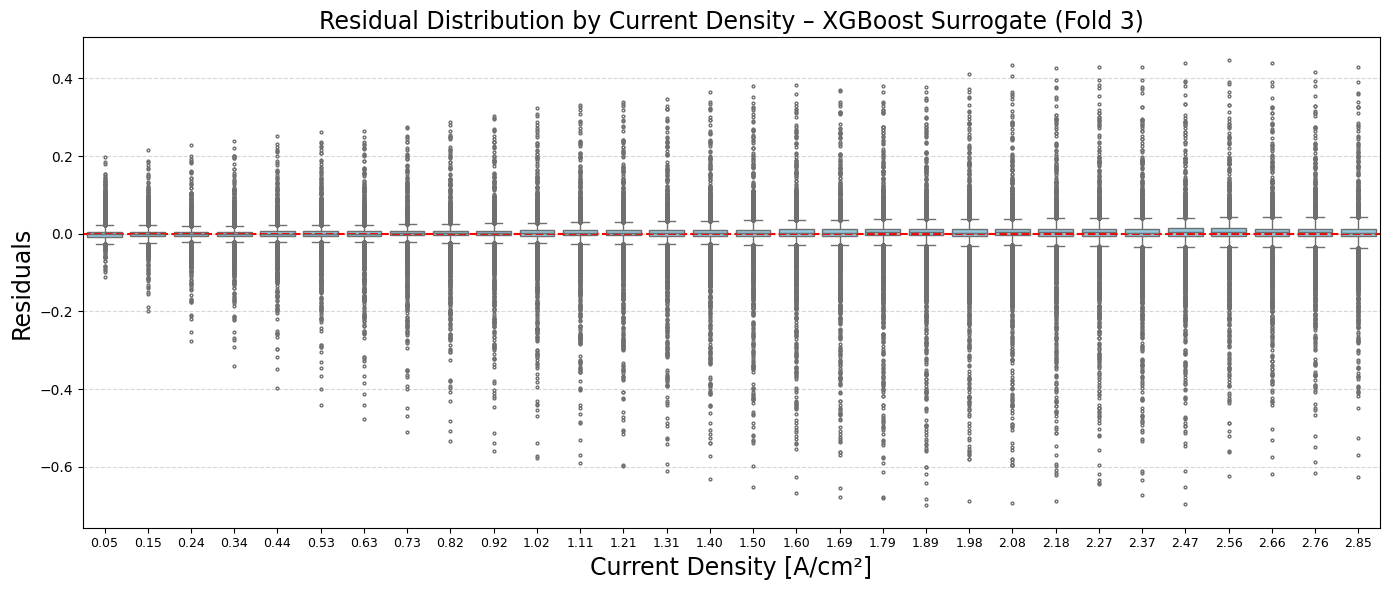

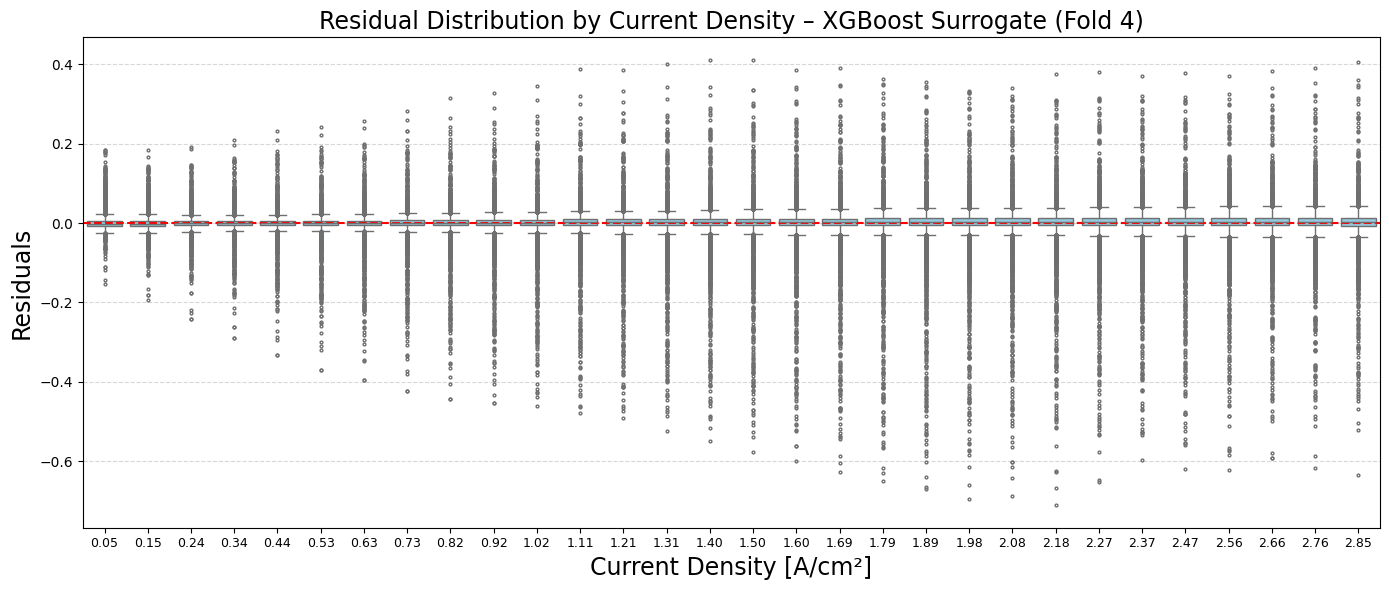

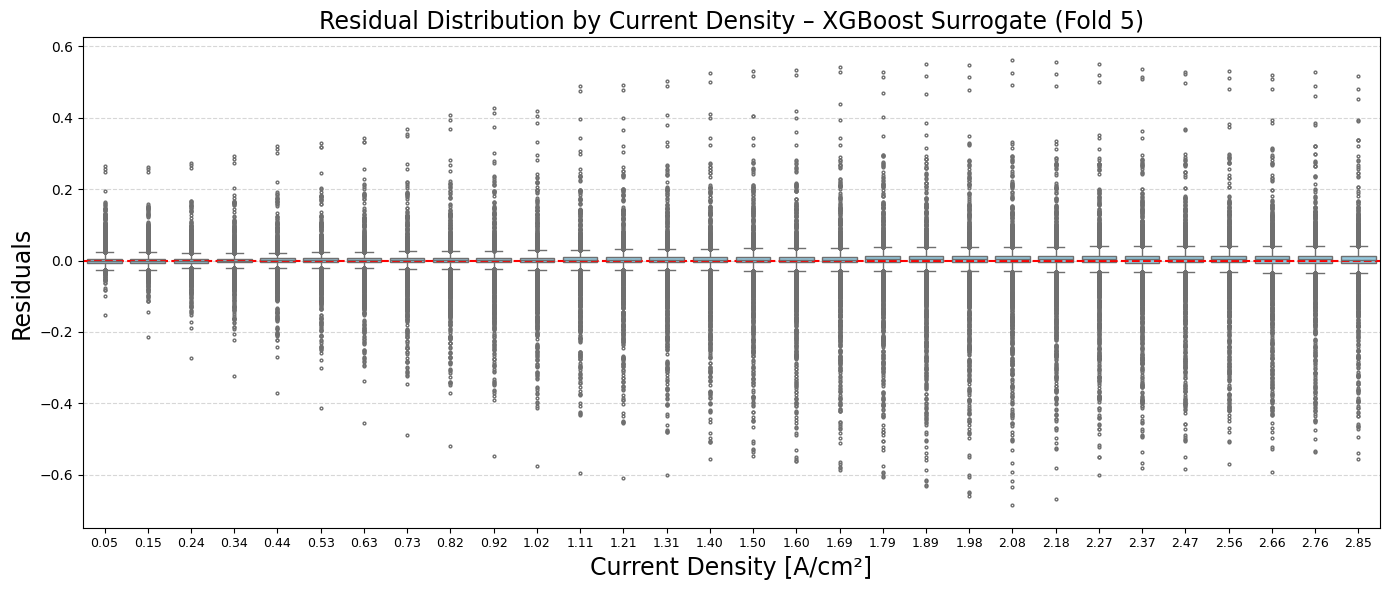

In [18]:
# Example usage
for fold, df in enumerate(residual_dfs, start=1):
    plot_residuals_by_ifc_boxplots(df, df['residual'], figsize=(14, 6), title=f"Residual Distribution by Current Density – XGBoost Surrogate (Fold {fold})")